# Import Libraries

In [46]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime as dt
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten, Layer
from tensorflow.keras import backend as K
from scikeras.wrappers import KerasClassifier
import optuna
from optuna.integration import TFKerasPruningCallback, XGBoostPruningCallback
import joblib
import warnings
warnings.filterwarnings('ignore')
from xgboost.callback import EarlyStopping
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import KFold


print("✅ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")


✅ Libraries imported successfully
TensorFlow version: 2.20.0


# Load MIMIC Perform AF Dataset

**Dataset info:**
- AF: 16 pasien (mimic_perform_af_001 - mimic_perform_af_016)
- Non-AF: 16 pasien (mimic_perform_non_af_001 - mimic_perform_non_af_016)
- Sampling Rate: 125Hz
- Duration: ~20 menit per pasien (150,000 samples)
- Columns: Time, PPG, ECG, resp

In [2]:
# Path configuration
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))

af_folder = os.path.join(project_root, 'Data', 'af')
nonaf_folder = os.path.join(project_root, 'Data', 'non-af')

# List files - Balance: AF only up to patient 16
af_files_all = sorted(glob.glob(os.path.join(af_folder, '*_data.csv')))
af_files = af_files_all[:16]
nonaf_files = sorted(glob.glob(os.path.join(nonaf_folder, '*_data.csv')))

print("="*60)
print("DATASET: MIMIC Perform AF (Balanced)")
print("="*60)
print(f"\n📁 AF Folder: {af_folder}")
print(f"   Patients: {len(af_files)}")
print(f"\n📁 Non-AF Folder: {nonaf_folder}")
print(f"   Patients: {len(nonaf_files)}")
print(f"\n📊 Total Patients: {len(af_files) + len(nonaf_files)}")

DATASET: MIMIC Perform AF (Balanced)

📁 AF Folder: c:\Users\Lenovo\Documents\GitHub\FP_MLxDM\Data\af
   Patients: 16

📁 Non-AF Folder: c:\Users\Lenovo\Documents\GitHub\FP_MLxDM\Data\non-af
   Patients: 16

📊 Total Patients: 32


## Train-Test Split (Sesuai Jurnal: 65% Train, 35% Test)

Split berdasarkan pasien untuk menghindari data leakage

In [3]:
# Split 65% train, 35% test (sesuai jurnal)
# Split per kelas untuk menjaga proporsi

np.random.seed(42)

# Shuffle files
af_files_shuffled = np.random.permutation(af_files).tolist()
nonaf_files_shuffled = np.random.permutation(nonaf_files).tolist()

# Split AF: 65% train, 35% test
n_af_train = int(len(af_files) * 0.65)
train_af = af_files_shuffled[:n_af_train]
test_af = af_files_shuffled[n_af_train:]

# Split Non-AF: 65% train, 35% test
n_nonaf_train = int(len(nonaf_files) * 0.65)
train_nonaf = nonaf_files_shuffled[:n_nonaf_train]
test_nonaf = nonaf_files_shuffled[n_nonaf_train:]

print("="*60)
print("DATA SPLIT (Sesuai Jurnal: 65% Train, 35% Test)")
print("="*60)
print(f"\n📊 AF Split:")
print(f"   Train: {len(train_af)} patients")
print(f"   Test: {len(test_af)} patients")
print(f"\n📊 Non-AF Split:")
print(f"   Train: {len(train_nonaf)} patients")
print(f"   Test: {len(test_nonaf)} patients")
print(f"\n📊 Total:")
print(f"   Train: {len(train_af) + len(train_nonaf)} patients")
print(f"   Test: {len(test_af) + len(test_nonaf)} patients")

DATA SPLIT (Sesuai Jurnal: 65% Train, 35% Test)

📊 AF Split:
   Train: 10 patients
   Test: 6 patients

📊 Non-AF Split:
   Train: 10 patients
   Test: 6 patients

📊 Total:
   Train: 20 patients
   Test: 12 patients


## Load Data Function

In [4]:
def load_patient_data(file_path, max_samples=150000):
    """
    Load ECG data dari file CSV.
    """
    df = pd.read_csv(file_path)
    
    # Limit samples
    if len(df) > max_samples:
        df = df.iloc[:max_samples]
    
    # Get ECG column
    ecg = df['ECG'].values
    
    # Handle NaN
    if np.any(np.isnan(ecg)):
        ecg = pd.Series(ecg).interpolate().values
    
    return ecg

print("✅ Load function defined")

✅ Load function defined


## Feature Extraction (Sesuai Jurnal)

5 fitur statistik per window:
1. Skewness
2. Kurtosis
3. Minimum
4. Maximum
5. Standard Deviation

In [5]:
# Parameters
SAMPLING_RATE = 125  # Hz
WINDOW_SIZE = SAMPLING_RATE  # 1 second = 125 samples
SEQUENCE_LENGTH = 10  # 10 windows = 10 seconds context

def extract_statistical_features(window):
    """
    Extract 5 statistical features (sesuai jurnal):
    Skewness, Kurtosis, Min, Max, STD
    """
    return np.array([
        skew(window),
        kurtosis(window),
        np.min(window),
        np.max(window),
        np.std(window)
    ])

def extract_features_from_signal(ecg_signal, window_size=125):
    """
    Extract features dari ECG signal.
    """
    n_windows = len(ecg_signal) // window_size
    features = []
    
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        window = ecg_signal[start:end]
        features.append(extract_statistical_features(window))
    
    return np.array(features)

print(f"📊 Parameters:")
print(f"   Sampling Rate: {SAMPLING_RATE} Hz")
print(f"   Window Size: {WINDOW_SIZE} samples (1 second)")
print(f"   Sequence Length: {SEQUENCE_LENGTH} windows")
print(f"   Features: 5 (Skewness, Kurtosis, Min, Max, STD)")

📊 Parameters:
   Sampling Rate: 125 Hz
   Window Size: 125 samples (1 second)
   Sequence Length: 10 windows
   Features: 5 (Skewness, Kurtosis, Min, Max, STD)


## Load and Extract Features

In [6]:
def load_and_extract(files, label, desc=""):
    """
    Load files dan extract features.
    """
    all_features = []
    all_labels = []
    
    for f in files:
        patient_id = os.path.basename(f).replace('_data.csv', '')
        print(f"   Loading {patient_id}...", end=" ")
        
        # Load ECG
        ecg = load_patient_data(f)
        
        # Extract features
        features = extract_features_from_signal(ecg, WINDOW_SIZE)
        labels = np.full(len(features), label)
        
        all_features.append(features)
        all_labels.append(labels)
        
        print(f"{len(features)} windows")
    
    return np.vstack(all_features), np.concatenate(all_labels)

# Load Training Data
print("="*60)
print("LOADING TRAINING DATA")
print("="*60)

print("\n📥 Loading AF patients (Train)...")
X_train_af, y_train_af = load_and_extract(train_af, label=1)

print("\n📥 Loading Non-AF patients (Train)...")
X_train_nonaf, y_train_nonaf = load_and_extract(train_nonaf, label=0)

# Combine training data
X_train = np.vstack([X_train_af, X_train_nonaf])
y_train = np.concatenate([y_train_af, y_train_nonaf])

print("\n" + "="*60)
print("LOADING TEST DATA")
print("="*60)

print("\n📥 Loading AF patients (Test)...")
X_test_af, y_test_af = load_and_extract(test_af, label=1)

print("\n📥 Loading Non-AF patients (Test)...")
X_test_nonaf, y_test_nonaf = load_and_extract(test_nonaf, label=0)

# Combine test data
X_test = np.vstack([X_test_af, X_test_nonaf])
y_test = np.concatenate([y_test_af, y_test_nonaf])

print("\n" + "="*60)
print("✅ DATA LOADED")
print("="*60)
print(f"\n📊 Training Data:")
print(f"   Samples: {len(X_train)}")
print(f"   AF: {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")
print(f"   Non-AF: {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"\n📊 Test Data:")
print(f"   Samples: {len(X_test)}")
print(f"   AF: {np.sum(y_test==1)} ({np.sum(y_test==1)/len(y_test)*100:.1f}%)")
print(f"   Non-AF: {np.sum(y_test==0)} ({np.sum(y_test==0)/len(y_test)*100:.1f}%)")

LOADING TRAINING DATA

📥 Loading AF patients (Train)...
   Loading mimic_perform_af_001... 1200 windows
   Loading mimic_perform_af_002... 1200 windows
   Loading mimic_perform_af_006... 1200 windows
   Loading mimic_perform_af_015... 1200 windows
   Loading mimic_perform_af_014... 1200 windows
   Loading mimic_perform_af_012... 1200 windows
   Loading mimic_perform_af_009... 1200 windows
   Loading mimic_perform_af_010... 1200 windows
   Loading mimic_perform_af_003... 1200 windows
   Loading mimic_perform_af_016... 1200 windows

📥 Loading Non-AF patients (Train)...
   Loading mimic_perform_non_af_007... 1200 windows
   Loading mimic_perform_non_af_003... 1200 windows
   Loading mimic_perform_non_af_009... 1200 windows
   Loading mimic_perform_non_af_014... 1200 windows
   Loading mimic_perform_non_af_010... 1200 windows
   Loading mimic_perform_non_af_013... 1200 windows
   Loading mimic_perform_non_af_011... 1200 windows
   Loading mimic_perform_non_af_004... 1200 windows
   Loading

## Preprocessing

In [7]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features normalized")
print(f"   Train shape: {X_train_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")

✅ Features normalized
   Train shape: (24000, 5)
   Test shape: (14400, 5)


In [8]:
def create_sequences(data, labels, sequence_length=10):
    """
    Create sequences for LSTM.
    """
    X_seq = []
    y_seq = []
    
    for i in range(len(data) - sequence_length + 1):
        X_seq.append(data[i:i+sequence_length])
        y_seq.append(labels[i+sequence_length-1])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
print(f"Creating sequences with {SEQUENCE_LENGTH} timesteps...")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQUENCE_LENGTH)

print(f"\n✅ Sequences created:")
print(f"   X_train: {X_train_seq.shape}")
print(f"   X_test: {X_test_seq.shape}")

Creating sequences with 10 timesteps...

✅ Sequences created:
   X_train: (23991, 10, 5)
   X_test: (14391, 10, 5)


# Transfomer Model 

### Grid Search

#### Model

In [9]:
def build_lstm_model(n_timesteps=SEQUENCE_LENGTH, n_features=5, lstm_units=64, dropout_rate=0.2):
    """
    Build LSTM model for Grid Search
    """
    inputs = Input(shape=(n_timesteps, n_features))
    x = LSTM(lstm_units, return_sequences=False)(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap model for scikit-learn
keras_clf = KerasClassifier(
    build_fn=build_lstm_model,
    n_timesteps=SEQUENCE_LENGTH,
    n_features=5,
    verbose=0
)

# Hyperparameter grid
param_grid = {
    'epochs': [20, 30],
    'batch_size': [32, 64],
    'model__lstm_units': [32, 64],
    'model__dropout_rate': [0.1, 0.2]
}

# Define GridSearchCV
grid = GridSearchCV(
    estimator=keras_clf, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1
)

print("✅ LSTM model and GridSearchCV defined")
print(f"   Total combinations: {len(param_grid['epochs']) * len(param_grid['batch_size']) * len(param_grid['model__lstm_units']) * len(param_grid['model__dropout_rate'])}")


✅ LSTM model and GridSearchCV defined
   Total combinations: 16


#### Running

In [10]:
# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(enumerate(class_weights_array))

# Fit GridSearchCV
grid_result = grid.fit(X_train_seq, y_train_seq)

#### Save Model

In [38]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\Users\Lenovo\Documents\GitHub\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'LSTM')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'xgboost_LSTM_grid_{timestamp}.joblib')
best_lstm_model = grid_result.best_estimator_.model_
joblib.dump(best_lstm_model, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\Users\Lenovo\Documents\GitHub\FP_MLxDM\models\LSTM\xgboost_LSTM_grid_10122025_113333.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Grid Search

Score: 0.4919 (+/- 0.2191)

Params: {'batch_size': 64, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__ff_dim': 64, 'model__num_heads': 4}



GRID SEARCH RESULTS

✅ Best Score: 0.2783

📊 Best Hyperparameters:
   batch_size: 32
   epochs: 30
   model__dropout_rate: 0.1
   model__lstm_units: 32

📊 Top 5 Configurations:

   Rank 1:
      Score: 0.2783 (+/- 0.1540)
      Params: {'batch_size': 32, 'epochs': 30, 'model__dropout_rate': 0.1, 'model__lstm_units': 32}

   Rank 2:
      Score: 0.2684 (+/- 0.1413)
      Params: {'batch_size': 64, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__lstm_units': 64}

   Rank 3:
      Score: 0.2664 (+/- 0.1360)
      Params: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.1, 'model__lstm_units': 32}

   Rank 4:
      Score: 0.2659 (+/- 0.1358)
      Params: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__lstm_units': 64}

   Rank 5:
      Score: 0.2611 (+/- 0.1369)
      Params: {'batch_size': 64, 'epochs': 30, 'model__dropout_rate': 0.2, 'model__lstm_units': 32}
GRID SEARCH RESULTS VISUALIZATION


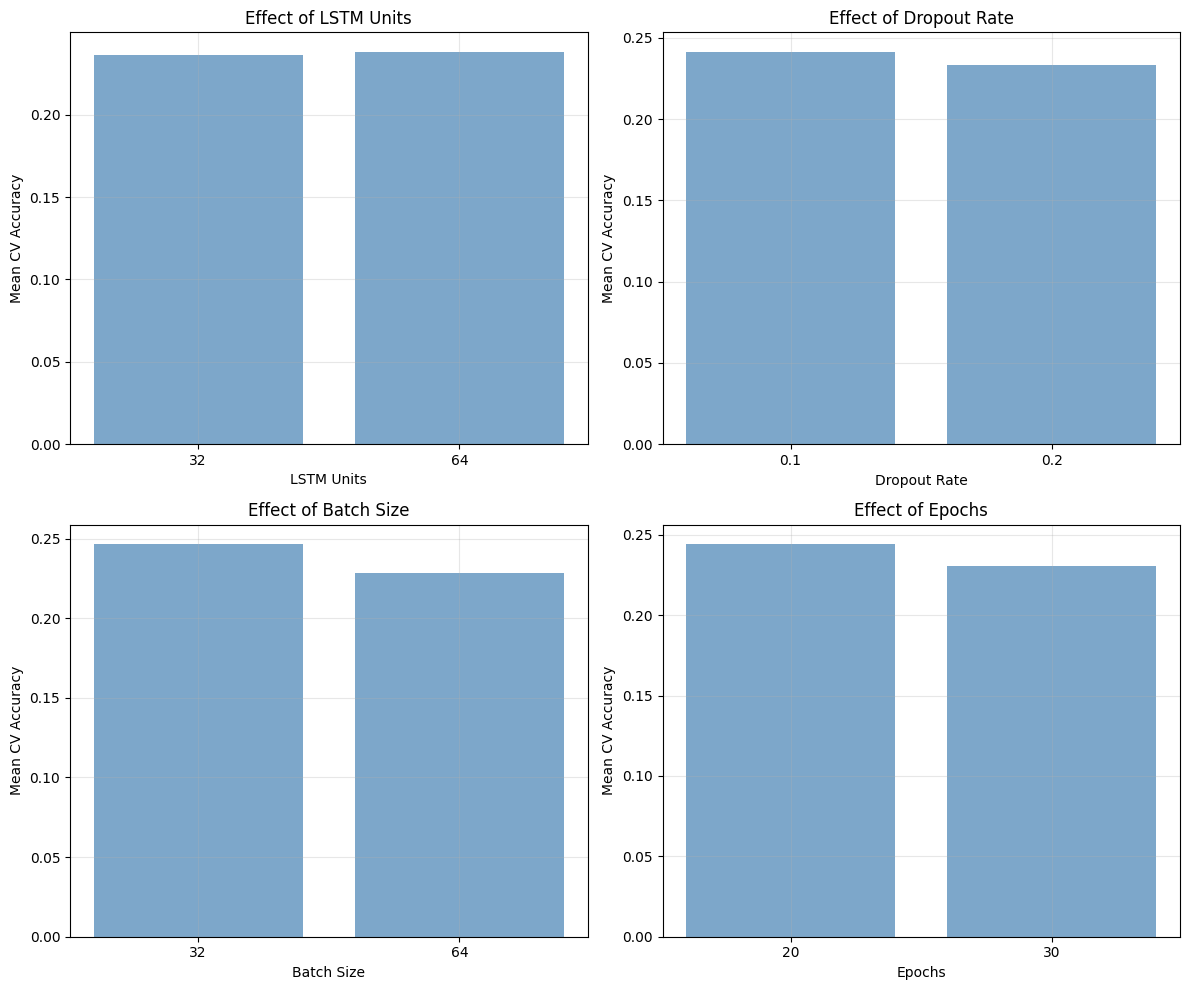


✅ Best Configuration:
   Accuracy: 0.2783
   batch_size: 32
   epochs: 30
   model__dropout_rate: 0.1
   model__lstm_units: 32


In [13]:
print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"\n✅ Best Score: {grid_result.best_score_:.4f}")
print(f"\n📊 Best Hyperparameters:")
for param, value in grid_result.best_params_.items():
    print(f"   {param}: {value}")

print("\n📊 Top 5 Configurations:")
results_df = pd.DataFrame(grid_result.cv_results_)
results_df = results_df.sort_values('rank_test_score')
for idx, row in results_df.head(5).iterrows():
    print(f"\n   Rank {int(row['rank_test_score'])}:")
    print(f"      Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"      Params: {row['params']}")

# Visualize Grid Search Results
print("="*60)
print("GRID SEARCH RESULTS VISUALIZATION")
print("="*60)

# Create results dataframe
results_df = pd.DataFrame(grid_result.cv_results_)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Hyperparameter vs Score plots
params_to_plot = ['param_model__lstm_units', 'param_model__dropout_rate', 'param_batch_size', 'param_epochs']
titles = ['LSTM Units', 'Dropout Rate', 'Batch Size', 'Epochs']

for idx, (param, title) in enumerate(zip(params_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    grouped = results_df.groupby(param)['mean_test_score'].mean()
    ax.bar(range(len(grouped)), grouped.values, color='steelblue', alpha=0.7)
    ax.set_xticks(range(len(grouped)))
    ax.set_xticklabels([str(x) for x in grouped.index])
    ax.set_xlabel(title)
    ax.set_ylabel('Mean CV Accuracy')
    ax.set_title(f'Effect of {title}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'grid_search_results_lstm.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Best Configuration:")
print(f"   Accuracy: {grid_result.best_score_:.4f}")
for param, value in grid_result.best_params_.items():
    print(f"   {param}: {value}")


### Extract Feature 

In [14]:
# Extract features from best Grid Search Transformer model for XGBoost
best_transformer_model = grid_result.best_estimator_.model_

# Build feature extractor from the second-to-last layer
gs_feature_extractor = Model(
    inputs=best_transformer_model.inputs,
    outputs=best_transformer_model.layers[-2].output
)

# Extract features
print("Extracting features from Grid Search Transformer model...")
X_train_weights_gs = gs_feature_extractor.predict(X_train_seq, verbose=0)
X_test_weights_gs = gs_feature_extractor.predict(X_test_seq, verbose=0)

print("✅ Features extracted from Grid Search Transformer model")
print(f"   Train: {X_train_weights_gs.shape}")
print(f"   Test: {X_test_weights_gs.shape}")

Extracting features from Grid Search Transformer model...
✅ Features extracted from Grid Search Transformer model
   Train: (23991, 32)
   Test: (14391, 32)


### Optuna

#### Model

In [35]:
def create_lstm_model_optuna(trial):
    """
    Create LSTM model with Optuna hyperparameters
    """
    # Hyperparameters to tune
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    ff_dim = trial.suggest_categorical('ff_dim', [32, 64, 128])

    # Build model
    inputs = Input(shape=(SEQUENCE_LENGTH, 5))
    x = LSTM(lstm_units, return_sequences=False)(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("✅ LSTM model for Optuna defined")


✅ LSTM model for Optuna defined


#### Running

In [36]:
def objective(trial):
    """
    Optuna objective function for LSTM hyperparameter tuning
    """
    # Hyperparameters to tune
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 20, 50)
    
    # Create model
    model = create_lstm_model_optuna(trial)
    
    # Class weights
    class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
    class_weight_dict = dict(enumerate(class_weights_array))
    
    # Train model
    history = model.fit(
        X_train_seq, y_train_seq,
        batch_size=batch_size,
        epochs=epochs,
        class_weight=class_weight_dict,
        validation_split=0.2,
        verbose=0,
        callbacks=[TFKerasPruningCallback(trial, 'val_accuracy')]
    )
    
    return history.history['val_accuracy'][-1]

# Run Optuna optimization
print("="*60)
print("OPTUNA HYPERPARAMETER TUNING - LSTM")
print("="*60)
print("\nStarting Optuna optimization...")

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\n" + "="*60)
print("OPTUNA RESULTS")
print("="*60)
print(f"\n✅ Best Accuracy: {study.best_value:.4f}")
print(f"\n📊 Best Hyperparameters:")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")

[I 2025-12-10 11:19:29,369] A new study created in memory with name: no-name-7046d948-920a-4b14-8e10-372ed08d5f27


OPTUNA HYPERPARAMETER TUNING - LSTM

Starting Optuna optimization...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-10 11:21:20,160] Trial 0 finished with value: 0.0006251302547752857 and parameters: {'batch_size': 64, 'epochs': 39, 'lstm_units': 128, 'dropout_rate': 0.1246526796189031, 'learning_rate': 0.00011102124836213887, 'ff_dim': 32}. Best is trial 0 with value: 0.0006251302547752857.
[I 2025-12-10 11:21:40,282] Trial 1 finished with value: 0.000833506986964494 and parameters: {'batch_size': 128, 'epochs': 24, 'lstm_units': 32, 'dropout_rate': 0.40643381527471967, 'learning_rate': 0.0009191046435931346, 'ff_dim': 64}. Best is trial 1 with value: 0.000833506986964494.
[I 2025-12-10 11:23:33,690] Trial 2 finished with value: 0.0006251302547752857 and parameters: {'batch_size': 32, 'epochs': 38, 'lstm_units': 64, 'dropout_rate': 0.2566617885049246, 'learning_rate': 0.0002014353257379716, 'ff_dim': 128}. Best is trial 1 with value: 0.000833506986964494.
[I 2025-12-10 11:24:56,385] Trial 3 finished with value: 0.0006251302547752857 and parameters: {'batch_size': 32, 'epochs': 36, 'lstm_

#### Save Model

In [37]:
# Save best Optuna LSTM model
os.makedirs('models/TRANSFORMER', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

# Rebuild model with best params and retrain on full data
best_trial = study.best_trial
best_model = create_lstm_model_optuna(best_trial)

# Class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(enumerate(class_weights_array))

# Retrain on full data
best_model.fit(
    X_train_seq, y_train_seq,
    batch_size=best_trial.params['batch_size'],
    epochs=best_trial.params['epochs'],
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7251 - loss: 0.5950
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8870 - loss: 0.3216
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9678 - loss: 0.1418
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9766 - loss: 0.0901
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9789 - loss: 0.0771
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9817 - loss: 0.0682
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9827 - loss: 0.0623
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9838 - loss: 0.0576
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9849 - loss: 0.0531
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9862 - loss: 0.0491
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9869 - loss: 0.0458
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [39]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\Users\Lenovo\Documents\GitHub\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'LSTM')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'xgboost_LSTM_optuna_{timestamp}.joblib')

joblib.dump(best_model, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\Users\Lenovo\Documents\GitHub\FP_MLxDM\models\LSTM\xgboost_LSTM_optuna_10122025_113333.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Optuna

✅ Best Optuna Configuration:
  - Accuracy: 0.4968
  - batch_size: 64
  - epochs: 41
  - num_heads: 8
  - ff_dim: 128
  - dropout_rate: 0.4037450941514691
  - learning_rate: 0.00010064162612495603

OPTUNA RESULTS VISUALIZATION


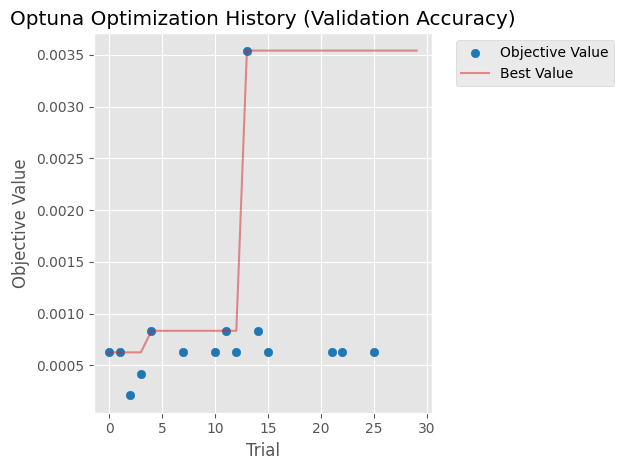

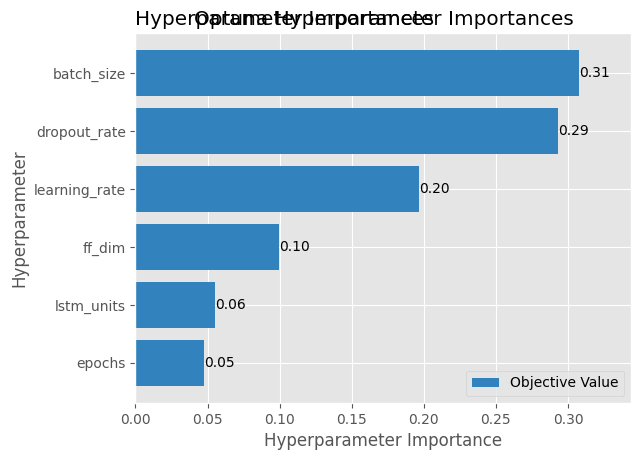


✅ Best Optuna Configuration:
   Accuracy: 0.0035
   batch_size: 128
   epochs: 30
   lstm_units: 64
   dropout_rate: 0.31830113453925385
   learning_rate: 0.00010703771120211154
   ff_dim: 64


In [22]:
# Visualisasi hasil Optuna Transformer

print("="*60)
print("OPTUNA RESULTS VISUALIZATION")
print("="*60)

# Plot optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History (Validation Accuracy)")
plt.show()

# Plot parameter importance
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Optuna Hyperparameter Importances")
plt.show()

# Print best trial summary
print(f"\n✅ Best Optuna Configuration:")
print(f"   Accuracy: {study.best_value:.4f}")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")

#### Extraxt Feature

In [23]:
# Extract features from best Optuna Transformer model for XGBoost
# Build feature extractor from the second-to-last layer
optuna_feature_extractor = Model(
    inputs=best_model.inputs,
    outputs=best_model.layers[-2].output
)

print("Extracting features from Optuna Transformer model...")
X_train_weights_optuna = optuna_feature_extractor.predict(X_train_seq, verbose=0)
X_test_weights_optuna = optuna_feature_extractor.predict(X_test_seq, verbose=0)

print("✅ Features extracted from Optuna Transformer model")
print(f"   Train: {X_train_weights_optuna.shape}")
print(f"   Test: {X_test_weights_optuna.shape}")

Extracting features from Optuna Transformer model...
✅ Features extracted from Optuna Transformer model
   Train: (23991, 64)
   Test: (14391, 64)


### Default

#### Model

In [24]:
# Build default LSTM model
def build_lstm_model_default(n_timesteps=SEQUENCE_LENGTH, n_features=5, lstm_units=64, dropout_rate=0.2):
    """
    Build default LSTM model.
    """
    inputs = Input(shape=(n_timesteps, n_features))
    x = LSTM(lstm_units, return_sequences=False)(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("✅ Default LSTM model defined")


✅ Default LSTM model defined


#### Training

In [25]:
# Build default LSTM model
model = build_lstm_model_default(
    n_timesteps=SEQUENCE_LENGTH,
    n_features=5,
    lstm_units=64,
    dropout_rate=0.2
)

print("Model Architecture:")
model.summary()

# Train model (tanpa validation - sesuai jurnal)
print("\nTraining Default LSTM Model...")

# Class weights untuk handle imbalance
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(enumerate(class_weights_array))
print(f"Class weights: {class_weight_dict}")

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=1
)

print(f"\n✅ Training completed.")
print(f"   Final accuracy: {history.history['accuracy'][-1]:.4f}")


Model Architecture:


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)


Training Default LSTM Model...
Class weights: {0: np.float64(0.999625), 1: np.float64(1.0003752814610958)}
Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9375 - loss: 0.1541
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9916 - loss: 0.0297
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9957 - loss: 0.0157
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9967 - loss: 0.0118
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9980 - loss: 0.0075
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9980 - loss: 0.0068
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9972 - loss: 0.0098
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9977 - loss: 0.0074
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9991 - loss: 0.0034
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9989 - loss: 0.0034
Epoch 11/50
375/375 ━━━━━━━━━━

#### Save Model

In [40]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\Users\Lenovo\Documents\GitHub\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'LSTM')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'xgboost_LSTM_default_{timestamp}.joblib')

joblib.dump(model, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\Users\Lenovo\Documents\GitHub\FP_MLxDM\models\LSTM\xgboost_LSTM_default_10122025_113333.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Default

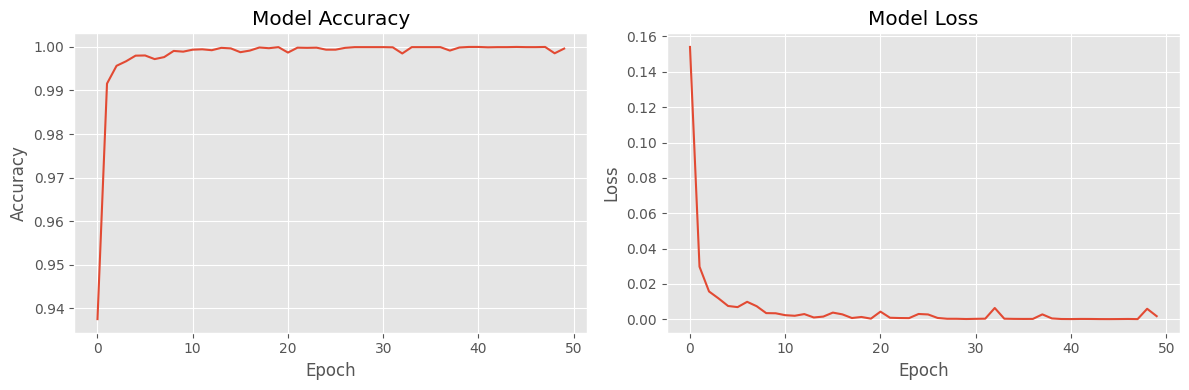

In [27]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Extract Features 

In [28]:
transformer_default_feature_extractor = Model( # Ubah nama
    inputs=model.inputs, 
    outputs=model.layers[-2].output 
)

# Extract features
print("Extracting features from Transformer model...")
X_train_weights_default = transformer_default_feature_extractor.predict(X_train_seq, verbose=0) # Ubah nama
X_test_weights_default = transformer_default_feature_extractor.predict(X_test_seq, verbose=0)   # Ubah nama

print("✅ Features extracted from Transformer model")
print(f"   Train: {X_train_weights_default.shape}")
print(f"   Test: {X_test_weights_default.shape}")

Extracting features from Transformer model...
✅ Features extracted from Transformer model
   Train: (23991, 64)
   Test: (14391, 64)


# XGBoost Classifier 

### Grid search

#### Model

In [41]:
# Parameter grid sesuai jurnal dan variasi
param_grid_xgb = {
    'eta': [0.1, 0.2, 0.3],
    'n_estimators': [100, 170, 200],
    'max_depth': [8, 10, 12]
}

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

#### Running

In [42]:
print("Training XGBoost GridSearchCV with features from Grid Search Transformer...")
grid_xgb.fit(X_train_weights_gs, y_train_seq)
print("✅ GridSearchCV completed")
print(f"Best params: {grid_xgb.best_params_}")
print(f"Best score: {grid_xgb.best_score_:.4f}")

Training XGBoost GridSearchCV with features from Grid Search Transformer...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


✅ GridSearchCV completed
Best params: {'eta': 0.1, 'max_depth': 8, 'n_estimators': 100}
Best score: 0.9998


#### Save Model

In [43]:
BASE_DIR = r"C:\Users\Lenovo\Documents\GitHub\FP_MLxDM"

MODEL_DIR = os.path.join(BASE_DIR, 'models', 'XGBOOST')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'xgboost_LSTM_grid_{timestamp}.joblib')

# Pastikan Anda menggunakan joblib.dump()
joblib.dump(grid_xgb.best_estimator_, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\Users\Lenovo\Documents\GitHub\FP_MLxDM\models\XGBOOST\xgboost_LSTM_grid_10122025_113344.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Grid Search

XGBOOST GRID SEARCH RESULTS

✅ Best Accuracy: 0.9998

📊 Best Hyperparameters:
   eta: 0.1
   max_depth: 8
   n_estimators: 100

📊 Top 5 Configurations:

   Rank 1:
      Accuracy: 0.9998 (+/- 0.0001)
      Params  : {'eta': 0.1, 'max_depth': 8, 'n_estimators': 100}

   Rank 1:
      Accuracy: 0.9998 (+/- 0.0001)
      Params  : {'eta': 0.1, 'max_depth': 8, 'n_estimators': 170}

   Rank 1:
      Accuracy: 0.9998 (+/- 0.0001)
      Params  : {'eta': 0.1, 'max_depth': 8, 'n_estimators': 200}

   Rank 1:
      Accuracy: 0.9998 (+/- 0.0001)
      Params  : {'eta': 0.1, 'max_depth': 10, 'n_estimators': 100}

   Rank 1:
      Accuracy: 0.9998 (+/- 0.0001)
      Params  : {'eta': 0.1, 'max_depth': 10, 'n_estimators': 170}

CONFUSION MATRIX & METRICS

✅ Performance Metrics:
   Accuracy : 0.5370 (53.70%)
   Precision: 0.5278 (52.78%)
   Recall   : 0.6959 (69.59%)
   F1 Score : 0.6003 (60.03%)
   ROC AUC  : 0.5733 (57.33%)


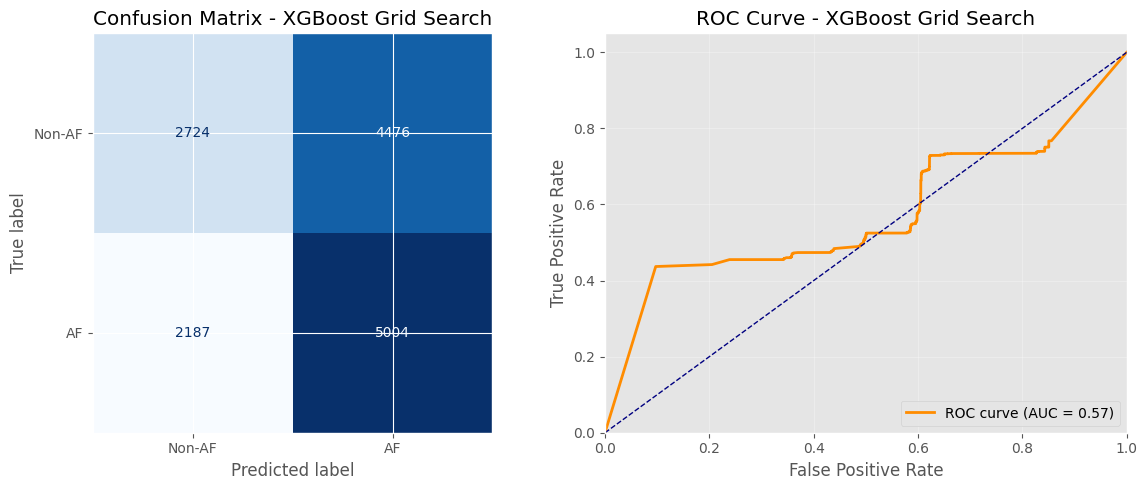


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Non-AF       0.55      0.38      0.45      7200
          AF       0.53      0.70      0.60      7191

    accuracy                           0.54     14391
   macro avg       0.54      0.54      0.53     14391
weighted avg       0.54      0.54      0.53     14391



In [44]:
print("="*60)
print("XGBOOST GRID SEARCH RESULTS")
print("="*60)

# Best Score & Hyperparameters
print(f"\n✅ Best Accuracy: {grid_xgb.best_score_:.4f}")
print(f"\n📊 Best Hyperparameters:")
for param, value in grid_xgb.best_params_.items():
    print(f"   {param}: {value}")

# Top 5 Configurations
results_xgb_df = pd.DataFrame(grid_xgb.cv_results_).sort_values('rank_test_score')
print("\n📊 Top 5 Configurations:")
for idx, row in results_xgb_df.head(5).iterrows():
    print(f"\n   Rank {int(row['rank_test_score'])}:")
    print(f"      Accuracy: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"      Params  : {row['params']}")

print("\n" + "="*60)
print("CONFUSION MATRIX & METRICS")
print("="*60)

# Metrics
y_pred_xgb = grid_xgb.predict(X_test_weights_gs)
y_prob_xgb = grid_xgb.predict_proba(X_test_weights_gs)[:, 1]
acc_xgb = accuracy_score(y_test_seq, y_pred_xgb)
prec_xgb = precision_score(y_test_seq, y_pred_xgb, zero_division=0)
recall_xgb = recall_score(y_test_seq, y_pred_xgb, zero_division=0)
f1_xgb = f1_score(y_test_seq, y_pred_xgb, zero_division=0)
rocauc_xgb = roc_auc_score(y_test_seq, y_prob_xgb) if len(np.unique(y_pred_xgb)) > 1 else 0.5

print(f"\n✅ Performance Metrics:")
print(f"   Accuracy : {acc_xgb:.4f} ({acc_xgb*100:.2f}%)")
print(f"   Precision: {prec_xgb:.4f} ({prec_xgb*100:.2f}%)")
print(f"   Recall   : {recall_xgb:.4f} ({recall_xgb*100:.2f}%)")
print(f"   F1 Score : {f1_xgb:.4f} ({f1_xgb*100:.2f}%)")
print(f"   ROC AUC  : {rocauc_xgb:.4f} ({rocauc_xgb*100:.2f}%)")

# Confusion Matrix & ROC Curve side by side
cm_xgb = confusion_matrix(y_test_seq, y_pred_xgb)
fpr, tpr, thresholds = roc_curve(y_test_seq, y_prob_xgb)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Non-AF', 'AF'])
disp_xgb.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix - XGBoost Grid Search')

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {rocauc_xgb:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - XGBoost Grid Search')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test_seq, y_pred_xgb, target_names=['Non-AF', 'AF'], zero_division=0))

### Optuna

#### Model

#### Running

In [47]:
# Optuna hyperparameter tuning for XGBoost (features from Optuna Transformer)
def objective_xgb(trial):
    param = {
        'eta': trial.suggest_float('eta', 0.05, 0.3),
        'max_depth': trial.suggest_int('max_depth', 6, 14),
        'n_estimators': trial.suggest_int('n_estimators', 100, 250),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
    xgb = XGBClassifier(**param)
    scores = []
    # 3-fold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(X_train_weights_optuna):
        X_tr, X_val = X_train_weights_optuna[train_idx], X_train_weights_optuna[val_idx]
        y_tr, y_val = y_train_seq[train_idx], y_train_seq[val_idx]
        xgb.fit(X_tr, y_tr)
        preds = xgb.predict(X_val)
        scores.append(accuracy_score(y_val, preds))
    return np.mean(scores)


study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print("\n✅ Best XGBoost Optuna params:")
for k, v in study_xgb.best_params.items():
    print(f"   {k}: {v}")
print(f"Best accuracy: {study_xgb.best_value:.4f}")

[I 2025-12-10 11:35:14,252] A new study created in memory with name: no-name-51f0cfac-20ee-48bb-ad24-8dfd13be475f


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-10 11:35:16,927] Trial 0 finished with value: 0.9986244841815681 and parameters: {'eta': 0.15493585132156867, 'max_depth': 7, 'n_estimators': 105, 'subsample': 0.7018375898326046, 'colsample_bytree': 0.9696896294774889}. Best is trial 0 with value: 0.9986244841815681.
[I 2025-12-10 11:35:20,075] Trial 1 finished with value: 0.9986244841815681 and parameters: {'eta': 0.2503994093250577, 'max_depth': 11, 'n_estimators': 127, 'subsample': 0.7317125816967825, 'colsample_bytree': 0.8319852593896195}. Best is trial 0 with value: 0.9986244841815681.
[I 2025-12-10 11:35:25,252] Trial 2 finished with value: 0.9984160726939267 and parameters: {'eta': 0.11121273421112872, 'max_depth': 14, 'n_estimators': 200, 'subsample': 0.8024880681320926, 'colsample_bytree': 0.8772647669746189}. Best is trial 0 with value: 0.9986244841815681.
[I 2025-12-10 11:35:29,373] Trial 3 finished with value: 0.9984994372889834 and parameters: {'eta': 0.08587475651051883, 'max_depth': 7, 'n_estimators': 160, '

In [48]:
# Train XGBoost with Optuna best parameters using features from Optuna Transformer
xgb_optuna = XGBClassifier(**study_xgb.best_params, use_label_encoder=False, eval_metric='logloss')

print("Training XGBoost with Optuna best parameters (Optuna Transformer features)...")
xgb_optuna.fit(X_train_weights_optuna, y_train_seq)
print("✅ XGBoost (Optuna) trained")

Training XGBoost with Optuna best parameters (Optuna Transformer features)...
✅ XGBoost (Optuna) trained


### Save Model

In [49]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\Users\Lenovo\Documents\GitHub\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'XGBOOST')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'xgboost_LSTM_optuna_{timestamp}.joblib')


joblib.dump(xgb_optuna, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\Users\Lenovo\Documents\GitHub\FP_MLxDM\models\XGBOOST\xgboost_LSTM_optuna_10122025_113701.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Optuna

HYBRID MODEL EVALUATION (Optuna Transformer + XGBoost)
Dataset: MIMIC Perform AF

📊 Performance Metrics:
   Accuracy : 0.5572 (55.72%)
   Precision: 0.5438 (54.38%)
   Recall   : 0.7066 (70.66%)
   F1 Score : 0.6146 (61.46%)
   ROC AUC  : 0.5252 (52.52%)


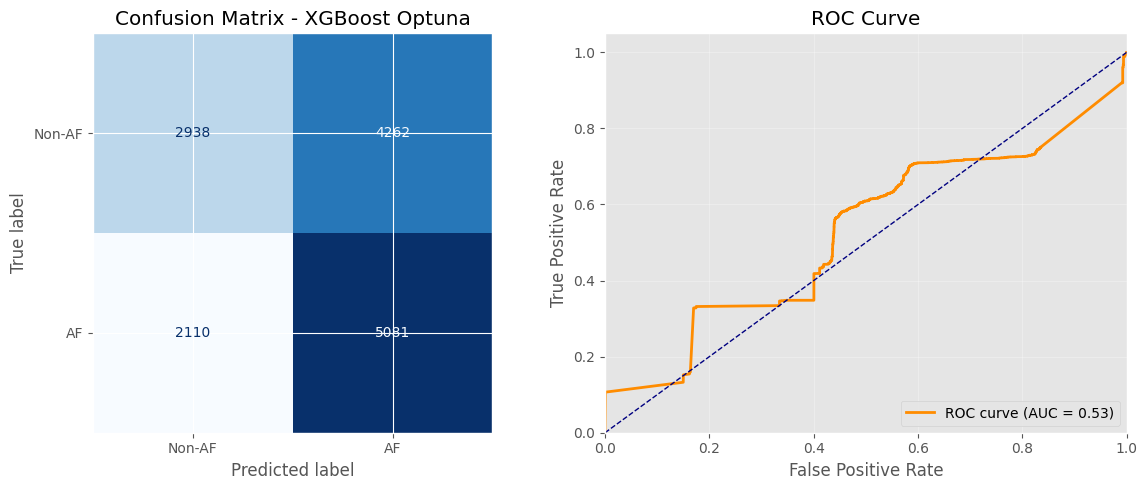


Classification Report:
              precision    recall  f1-score   support

      Non-AF       0.58      0.41      0.48      7200
          AF       0.54      0.71      0.61      7191

    accuracy                           0.56     14391
   macro avg       0.56      0.56      0.55     14391
weighted avg       0.56      0.56      0.55     14391



In [50]:
# Evaluate XGBoost Optuna model
y_prob_optuna = xgb_optuna.predict_proba(X_test_weights_optuna)[:, 1]
y_pred_optuna = xgb_optuna.predict(X_test_weights_optuna)

# Metrics
acc_optuna = accuracy_score(y_test_seq, y_pred_optuna)
prec_optuna = precision_score(y_test_seq, y_pred_optuna, zero_division=0)
recall_optuna = recall_score(y_test_seq, y_pred_optuna, zero_division=0)
f1_optuna = f1_score(y_test_seq, y_pred_optuna, zero_division=0)
roauc_optuna = roc_auc_score(y_test_seq, y_prob_optuna) if len(np.unique(y_pred_optuna)) > 1 else 0.5

print("="*60)
print("HYBRID MODEL EVALUATION (Optuna Transformer + XGBoost)")
print("Dataset: MIMIC Perform AF")
print("="*60)
print(f"\n📊 Performance Metrics:")
print(f"   Accuracy : {acc_optuna:.4f} ({acc_optuna*100:.2f}%)")
print(f"   Precision: {prec_optuna:.4f} ({prec_optuna*100:.2f}%)")
print(f"   Recall   : {recall_optuna:.4f} ({recall_optuna*100:.2f}%)")
print(f"   F1 Score : {f1_optuna:.4f} ({f1_optuna*100:.2f}%)")
print(f"   ROC AUC  : {roauc_optuna:.4f} ({roauc_optuna*100:.2f}%)")

# Confusion Matrix & ROC Curve
cm_optuna = confusion_matrix(y_test_seq, y_pred_optuna)
fpr, tpr, thresholds = roc_curve(y_test_seq, y_prob_optuna)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
disp_optuna = ConfusionMatrixDisplay(confusion_matrix=cm_optuna, display_labels=['Non-AF', 'AF'])
disp_optuna.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix - XGBoost Optuna')

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roauc_optuna:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_seq, y_pred_optuna, target_names=['Non-AF', 'AF'], zero_division=0))

### Default

#### Model

In [51]:
xgb_default = XGBClassifier()

#### Running

In [52]:
print("Training XGBoost Default (fitur ekstraksi default)...")
xgb_default.fit(X_train_weights_default, y_train_seq)
print("✅ XGBoost Default trained")

Training XGBoost Default (fitur ekstraksi default)...
✅ XGBoost Default trained


#### Save Model

In [53]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\Users\Lenovo\Documents\GitHub\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'XGBOOST')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'xgboost_LSTM_default_{timestamp}.joblib')


joblib.dump(xgb_default, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\Users\Lenovo\Documents\GitHub\FP_MLxDM\models\XGBOOST\xgboost_LSTM_default_10122025_113702.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Default

HYBRID MODEL EVALUATION (Default Transformer + XGBoost)
Dataset: MIMIC Perform AF

📊 Performance Metrics:
   Accuracy : 0.4954 (49.54%)
   Precision: 0.4954 (49.54%)
   Recall   : 0.5277 (52.77%)
   F1 Score : 0.5110 (51.10%)
   ROC AUC  : 0.4322 (43.22%)


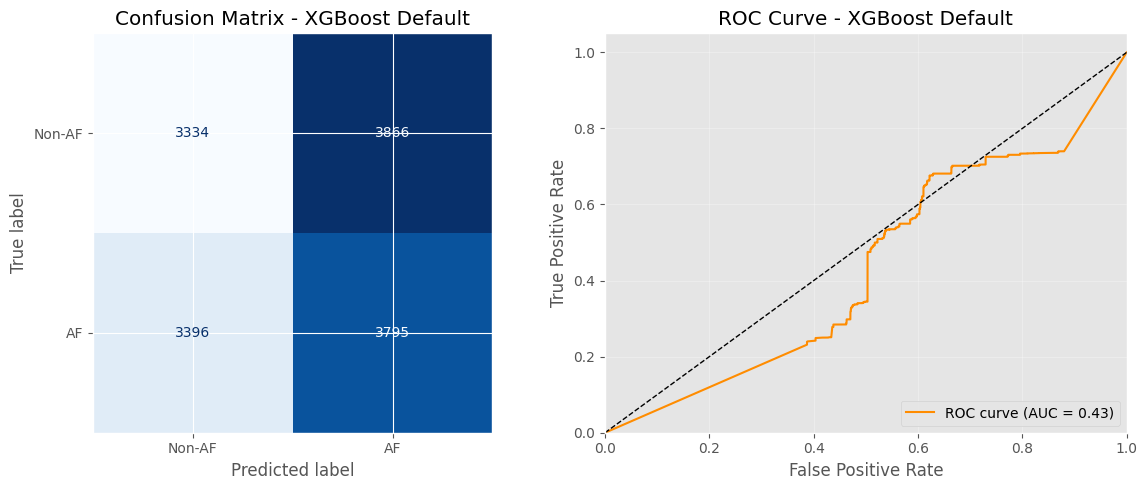


Classification Report:
              precision    recall  f1-score   support

      Non-AF       0.50      0.46      0.48      7200
          AF       0.50      0.53      0.51      7191

    accuracy                           0.50     14391
   macro avg       0.50      0.50      0.49     14391
weighted avg       0.50      0.50      0.49     14391



In [54]:
# Evaluate XGBoost Default model (template same as Optuna)

y_prob_default = xgb_default.predict_proba(X_test_weights_default)[:, 1]
y_pred_default = xgb_default.predict(X_test_weights_default)

# Metrics
acc_default = accuracy_score(y_test_seq, y_pred_default)
prec_default = precision_score(y_test_seq, y_pred_default, zero_division=0)
recall_default = recall_score(y_test_seq, y_pred_default, zero_division=0)
f1_default = f1_score(y_test_seq, y_pred_default, zero_division=0)
rocauc_default = roc_auc_score(y_test_seq, y_prob_default) if len(np.unique(y_pred_default)) > 1 else 0.5

print("="*60)
print("HYBRID MODEL EVALUATION (Default Transformer + XGBoost)")
print("Dataset: MIMIC Perform AF")
print("="*60)
print(f"\n📊 Performance Metrics:")
print(f"   Accuracy : {acc_default:.4f} ({acc_default*100:.2f}%)")
print(f"   Precision: {prec_default:.4f} ({prec_default*100:.2f}%)")
print(f"   Recall   : {recall_default:.4f} ({recall_default*100:.2f}%)")
print(f"   F1 Score : {f1_default:.4f} ({f1_default*100:.2f}%)")
print(f"   ROC AUC  : {rocauc_default:.4f} ({rocauc_default*100:.2f}%)")

# Confusion Matrix & ROC Curve side by side
cm_default = confusion_matrix(y_test_seq, y_pred_default)
fpr, tpr, thresholds = roc_curve(y_test_seq, y_prob_default)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=['Non-AF', 'AF'])
disp_default.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix - XGBoost Default')

# ROC Curve
axes[1].plot(fpr, tpr, label=f'ROC curve (AUC = {rocauc_default:.2f})', color='darkorange')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - XGBoost Default')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_seq, y_pred_default, target_names=['Non-AF', 'AF'], zero_division=0))

# Model Evaluation

### Perbandingan Metrics

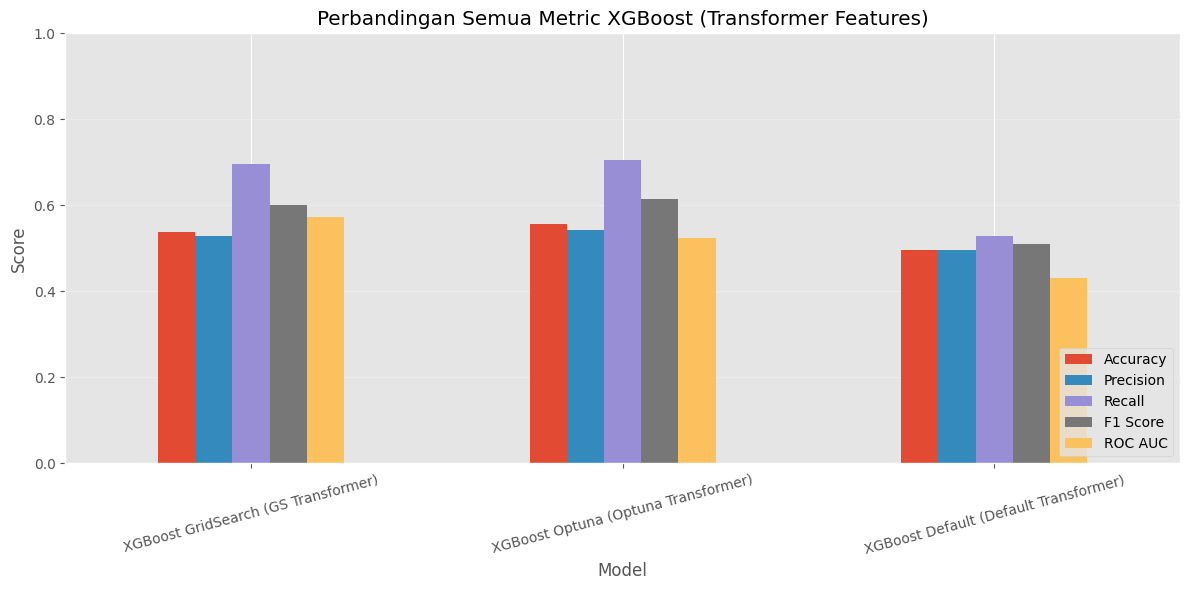

In [55]:
metrics_df = pd.DataFrame({
    'Model': [
        'XGBoost GridSearch (GS Transformer)', 
        'XGBoost Optuna (Optuna Transformer)', 
        'XGBoost Default (Default Transformer)'
    ],
    'Accuracy': [
        acc_xgb, 
        acc_optuna, 
        acc_default
    ],
    'Precision': [
        prec_xgb, 
        prec_optuna, 
        prec_default
    ],
    'Recall': [
        recall_xgb, 
        recall_optuna, 
        recall_default
    ],
    'F1 Score': [
        f1_xgb, 
        f1_optuna, 
        f1_default
    ],
    'ROC AUC': [
        rocauc_xgb, 
        roauc_optuna, 
        rocauc_default
    ]
})

# Visualisasi perbandingan metrik
metrics_plot = metrics_df.set_index('Model')
metrics_plot.plot(kind='bar', figsize=(12, 6))
plt.title('Perbandingan Semua Metric XGBoost (Transformer Features)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Summary

In [56]:
print("="*70)
print("SUMMARY")
print("="*70)

print("\n📋 DATASET: MIMIC Perform AF")
print(f"   AF Patients: {len(af_files)}")
print(f"   Non-AF Patients: {len(nonaf_files)}")
print(f"   Sampling Rate: {SAMPLING_RATE} Hz")

print("\n📋 DATA SPLIT (sesuai jurnal):")
print(f"   Train: {len(train_af)+len(train_nonaf)} patients (65%)")
print(f"   Test: {len(test_af)+len(test_nonaf)} patients (35%)")

print("\n📋 METHODOLOGY (sesuai jurnal):")
print("   1. Feature Extraction: 5 statistical features")
print("   2. Transformer-based feature extraction (GridSearch, Optuna, Default)")
print("   3. XGBoost classifier (GridSearch, Optuna, Default)")

print("\n📊 RESULTS (XGBoost GridSearch + GS Transformer):")
print(f"   Accuracy : {acc_xgb*100:.2f}%")
print(f"   Precision: {prec_xgb*100:.2f}%")
print(f"   Recall   : {recall_xgb*100:.2f}%")
print(f"   F1 Score : {f1_xgb*100:.2f}%")
print(f"   ROC AUC  : {rocauc_xgb*100:.2f}%")

print("\n📊 RESULTS (XGBoost Optuna + Optuna Transformer):")
print(f"   Accuracy : {acc_optuna*100:.2f}%")
print(f"   Precision: {prec_optuna*100:.2f}%")
print(f"   Recall   : {recall_optuna*100:.2f}%")
print(f"   F1 Score : {f1_optuna*100:.2f}%")
print(f"   ROC AUC  : {roauc_optuna*100:.2f}%")

print("\n📊 RESULTS (XGBoost Default + Default Transformer):")
print(f"   Accuracy : {acc_default*100:.2f}%")
print(f"   Precision: {prec_default*100:.2f}%")
print(f"   Recall   : {recall_default*100:.2f}%")
print(f"   F1 Score : {f1_default*100:.2f}%")
print(f"   ROC AUC  : {rocauc_default*100:.2f}%")

print("\n" + "="*70)

SUMMARY

📋 DATASET: MIMIC Perform AF
   AF Patients: 16
   Non-AF Patients: 16
   Sampling Rate: 125 Hz

📋 DATA SPLIT (sesuai jurnal):
   Train: 20 patients (65%)
   Test: 12 patients (35%)

📋 METHODOLOGY (sesuai jurnal):
   1. Feature Extraction: 5 statistical features
   2. Transformer-based feature extraction (GridSearch, Optuna, Default)
   3. XGBoost classifier (GridSearch, Optuna, Default)

📊 RESULTS (XGBoost GridSearch + GS Transformer):
   Accuracy : 53.70%
   Precision: 52.78%
   Recall   : 69.59%
   F1 Score : 60.03%
   ROC AUC  : 57.33%

📊 RESULTS (XGBoost Optuna + Optuna Transformer):
   Accuracy : 55.72%
   Precision: 54.38%
   Recall   : 70.66%
   F1 Score : 61.46%
   ROC AUC  : 52.52%

📊 RESULTS (XGBoost Default + Default Transformer):
   Accuracy : 49.54%
   Precision: 49.54%
   Recall   : 52.77%
   F1 Score : 51.10%
   ROC AUC  : 43.22%

